# Introduction

# Setup

## Helper Methods

In [2]:
def printl(msg):
    sys.stdout.write("\r" + str(msg))
    sys.stdout.flush()

## Imports

In [3]:
import math
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_breast_cancer, load_digits, make_blobs

%matplotlib inline

# PAM - Partitioning around Medoids

In [4]:
class CustomKMedoids(BaseEstimator, ClusterMixin):
    def __init__(self, k=10, plot=False):
        self.k = k
        self.plot = plot

        
    @property
    def cluster_centers_(self):
        return self._cluster_centers

    
    @property
    def clusters_(self):
        return self._clusters
    
    
    @property
    def cost_(self):
        return self._cost
    
    
    def fit(self, X):
        self.X = X
        self.xdim = X.shape[1]
        
        if self.xdim != 2 and self.plot == True:
            self.plot = False
        
        self._check_params(self.X)
        self._k_medoids(self.X)
        self.fitted_ = True
        
        return self
    
    
    def _k_medoids(self,X):
        medoids = []
        
        #initially taking first "k" points as medoids
        for i in range(self.k):
            medoids.append(X[i])
        medoids = np.array(medoids)
            
        clusters, cost = self._cluster(medoids)

        while True:
            #reassigning old medoids and cost w.r.t old medoids
            old_medoids = np.copy(medoids)
            old_clusters = dict(clusters)
            old_cost = cost
            
            #getting new medoids and clusters and cost w.r.t new medoids
            new_medoids = self._optimal_configuration(medoids)
            new_clusters, new_cost = self._cluster(new_medoids)
            
            
            if new_cost < old_cost:
                medoids = np.copy(new_medoids)
                clusters = dict(new_clusters)
                cost = new_cost
            elif new_cost == old_cost:
                #if medoids are equal then finishing
                optimized = True
                for i,medoid in enumerate(medoids):
                    if not np.array_equal(medoid, old_medoids[i]):
                        optimized = False
                        break
                if optimized == True: 
                    #medoids = self._optimal_local_configuration(medoids, clusters)
                    #clusters, cost = self._cluster(medoids)
                    break
                
        
        self._cluster_centers = medoids
        self._clusters = clusters
        self._cost = cost
        
        
    def _cluster(self, medoids, X=None):
        if X is None:
            X = self.X
            
        clusters = {}
        cost = 0
        
        for i in range(self.k):
            clusters[i] = []
            
        #assigning each point to its nearest medoid
        for x in X:
            distances = [np.linalg.norm(medoid-x) for medoid in medoids]

            # getting closest medoid from this point
            index = np.argmin(distances)
            
            #updating cost
            cost += distances[index]

            #adding point to its respective cluster
            clusters[index].append(x)
            
        return clusters, cost
            
    
    def _optimal_configuration(self, medoids):
        X = self.X
        
        new_medoids = []
        for i,medoid in enumerate(medoids):
            #getting cluster and cost of current medoids
            min_clusters, min_cost = self._cluster(medoids)
            new_medoid = medoid
            
            temp_medoids = np.copy(medoids)
            for x in min_clusters[i]:
                #changing the current medoid to current point
                temp_medoids[i] = x
                
                #computing new clusters and cost w.r.t to new point as medoid
                new_clusters, new_cost = self._cluster(temp_medoids)
                
                #updating cost, medoid and cluster if new cost < previous minimum cost
                if new_cost < min_cost:
                    min_cost = new_cost
                    new_medoid = x
                    min_clusters = new_clusters
            new_medoids.append(new_medoid)
        return np.array(new_medoids)
    
    
    def _optimal_local_configuration(self, medoids, clusters):
        new_medoids = []
        
        for i, medoid in enumerate(medoids):
            min_cost = self._local_cost(medoid, clusters[i])
            min_medoid = medoid
            
            for x in clusters[i]:
                if not np.array_equal(x, medoid):
                    new_cost = self._local_cost(x, clusters[i])
                    if new_cost < min_cost:
                        min_cost = new_cost
                        min_medoid = x
            
            new_medoids.append(min_medoid)
        return np.array(new_medoids)
    
    
    def _local_cost(self, medoid, cluster):
        cost = 0
        for x in cluster:
            if not np.array_equal(x, medoid):
                cost += np.linalg.norm(medoid-x)
            
        return cost
            
    

    def predict(self, X):
        y_preds = []
        for x in X:
            #getting eucledian distance of current points from each medoid
            distances = [np.linalg.norm(medoid-x) for medoid in self._cluster_centers]
            
            #getting index(class) of closes medoid from current point
            index = np.argmin(distances)
            
            y_preds.append(index)
        return np.array(y_preds)
    
    
    def _plot(self, old_medoids, new_medoids):
        plt.scatter(X[:,0], X[:,1])
        plt.scatter(old_medoids[:,0], old_medoids[:,1], c='g')
        plt.scatter(new_medoids[:,0], new_medoids[:,1], c='r')
        plt.show()
    
    
    def _check_params(self, X):
        pass

## Iris Dataset

In [5]:
iris = load_iris()
breast = load_breast_cancer()
digits = load_digits()

dataset = breast
X = dataset.data
y = dataset.target

In [6]:
%%time
custModel = CustomKMedoids(k=2).fit(X)
print(custModel.cluster_centers_)
print(custModel.cost_)

[[  1.25400000e+01   1.80700000e+01   7.94200000e+01   4.91900000e+02
    7.43600000e-02   2.65000000e-02   1.19400000e-03   5.44900000e-03
    1.52800000e-01   5.18500000e-02   3.51100000e-01   9.52700000e-01
    2.32900000e+00   2.83000000e+01   5.78300000e-03   4.69300000e-03
    7.92900000e-04   3.61700000e-03   2.04300000e-02   1.05800000e-03
    1.37200000e+01   2.09800000e+01   8.68200000e+01   5.85700000e+02
    9.29300000e-02   4.32700000e-02   3.58100000e-03   1.63500000e-02
    2.23300000e-01   5.52100000e-02]
 [  1.88200000e+01   2.19700000e+01   1.23700000e+02   1.11000000e+03
    1.01800000e-01   1.38900000e-01   1.59400000e-01   8.74400000e-02
    1.94300000e-01   6.13200000e-02   8.19100000e-01   1.93100000e+00
    4.49300000e+00   1.03900000e+02   8.07400000e-03   4.08800000e-02
    5.32100000e-02   1.83400000e-02   2.38300000e-02   4.51500000e-03
    2.26600000e+01   3.09300000e+01   1.45300000e+02   1.60300000e+03
    1.39000000e-01   3.46300000e-01   3.91200000e-01 

## Wikipedia Example

In [7]:
X = np.array([[2,6],[3,4],[3,8],[4,7],[6,2],[6,4],[7,3],[7,4],[8,5],[7,6]])

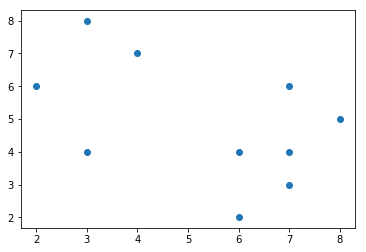

In [8]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [9]:
custModel = CustomKMedoids(k=2).fit(X)
print(custModel.cluster_centers_)
print(custModel.cost_)

[[2 6]
 [7 4]]
14.3584854724


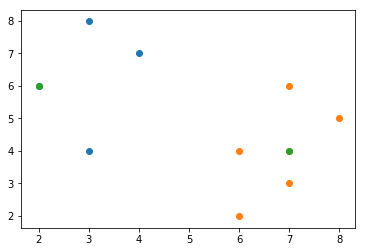

In [10]:
clusters = custModel.clusters_
for k in clusters:
    plt.scatter(np.array(clusters[k])[:,0], np.array(clusters[k])[:,1])
plt.scatter(custModel.cluster_centers_[:,0], custModel.cluster_centers_[:,1])
plt.show()

### Custom Dataset

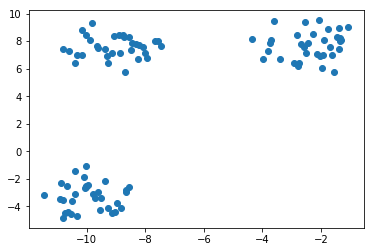

In [14]:
data = make_blobs(n_samples=100, centers=3)
X = data[0]
y = data[1]

plt.scatter(X[:,0], X[:,1])
plt.show()

In [15]:
custModel = CustomKMedoids(k=3, plot=True).fit(X)
print(custModel.cluster_centers_)
print(custModel.cost_)

[[-2.45737171  7.84560728]
 [-9.39443332  7.40382502]
 [-9.77404429 -3.07253358]]
117.19670841


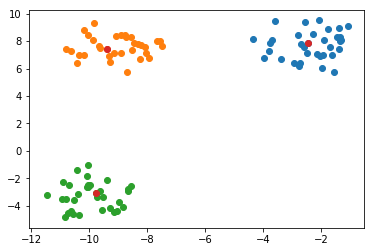

In [16]:
clusters = custModel.clusters_
for k in clusters:
    plt.scatter(np.array(clusters[k])[:,0], np.array(clusters[k])[:,1])
plt.scatter(custModel.cluster_centers_[:,0], custModel.cluster_centers_[:,1])
plt.show()